In [2]:
#imports go here

from sage.plot.polygon import Polygon
from sage.plot.colors import rainbow
import time
import threading

In [3]:
# This lets us not have to create a new matrix object every time we need to do a rotation.
# Just index into the dictionary with the angle you need to rotate by.
rot = {
    0 : matrix(2,2,[cos(0),-sin(0),sin(0),cos(0)]),
    pi/5 : matrix(2,2,[cos(pi/5),-sin(pi/5),sin(pi/5),cos(pi/5)]),
    2*pi/5: matrix(2,2,[cos(2*pi/5),-sin(2*pi/5),sin(2*pi/5),cos(2*pi/5)]),
    3*pi/5 : matrix(2,2,[cos(3*pi/5),-sin(3*pi/5),sin(3*pi/5),cos(3*pi/5)]),
    4*pi/5 : matrix(2,2,[cos(4*pi/5),-sin(4*pi/5),sin(4*pi/5),cos(4*pi/5)]),
    pi : matrix(2,2,[cos(pi),-sin(pi),sin(pi),cos(pi)]),
    6*pi/5 : matrix(2,2,[cos(6*pi/5),-sin(6*pi/5),sin(6*pi/5),cos(6*pi/5)]),
    7*pi/5 : matrix(2,2,[cos(7*pi/5),-sin(7*pi/5),sin(7*pi/5),cos(7*pi/5)]),
    8*pi/5 : matrix(2,2,[cos(8*pi/5),-sin(8*pi/5),sin(8*pi/5),cos(8*pi/5)]),
    9*pi/5 : matrix(2,2,[cos(9*pi/5),-sin(9*pi/5),sin(9*pi/5),cos(9*pi/5)]),
}

# Define constants to determine tile type. For information on the Penrose Kite-Dart, see: 
# https://tilings.math.uni-bielefeld.de/substitution/penrose-kite-dart/
# Note that the substitution given is not totally correct - it would cause overlapping tiles.
kite = 0
dart = 1


# Call this isntead of using rot directly. This way we don't have to hard-code
# all of the angles for a given substitution.
def rotate(theta):
    if rot[theta]:
        return rot[theta]
    rot[theta] = matrix(2,2,[cos(theta),-sin(theta),sin(theta),cos(theta)])
    return rot[theta]
    

# Calculates an angle theta mod 2pi, assuming theta is in the range [0, 4pi). Simplifies calculations.
def mod_2pi (theta):
    if theta >= 2*pi:
        return theta - 2*pi
    return theta



# TODO: Refactor this code to minimize time to generate tiles. Use a dictionary to describe 
# different supertiles for faster generation. 

class PenroseTile:
    
    # We define a supertile by:
    # shape, the tile 'type'; e.g. 'kite' or 'dart' as in the Penrose tiling
    # level, i.e. n where the supertile is L_n
    # orientation as a multiple of pi describing rotation around its center
    # origin, describing where to place this tile when moving up a level. The origin is the point that stays fixed
    #     when moving up a level.    
    def __init__(self, shape: int, level: int, orientation, origin: vector, parent):
        self.points = []
        self.shape = shape
        self.level = level
        self.orientation = mod_2pi(orientation)
        self.origin = origin
        self.id = 0
        self.adj = None
        self.vert_map = None
        self.prototile_ids = None

        # Track the supertile containing this tile. This way, we can keep an adjacency matrix
        # or a vert_map as a class variable, but still have the subtiles refer to the matrix/map
        # of the largest supertile. 
        if parent == None:
            self.parent = self
            self.vert_map = {}
            self.prototile_ids = []
            self.adj = None
        else:
            self.parent = parent
        

        if (level < 0):
            raise Exception("Level must be a non-negative integer.")
            
        #TODO: Add 2 extra vertices for between the long ends, to make it clearer
        if (level == 0):
            if self.parent.level != 0:
                self.id = self.parent.id
                self.parent.id += 1
            self.parent.prototile_ids.append(self)
            
            # dart prototile points
            if self.shape == dart:
                self.points = [vector(QQ[sin(pi/5)], (0 + origin[0], 0 + origin[1])),
                               vector(QQ[sin(pi/5)], (sin(pi/5) + origin[0], cos(pi/5) + origin[1])), 
                               vector(QQ[sin(pi/5)], (0 + origin[0], sec(pi/5)/2 + origin[1])),
                               vector(QQ[sin(pi/5)], (-sin(pi/5) + origin[0], cos(pi/5) + origin[1]))]
            
            # kite prototile points
            if self.shape == kite:
                self.points = [vector(QQ[sin(pi/5)], (0 + origin[0], 0 + origin[1])),
                               vector(QQ[sin(pi/5)], (cos(3*pi/10) + origin[0], sin(3*pi/10) + origin[1])), 
                               vector(QQ[sin(pi/5)], (0 + origin[0], 1 + origin[1])),
                               vector(QQ[sin(pi/5)], (-cos(3*pi/10) + origin[0], sin(3*pi/10) + origin[1]))]
                
            self.rotate_tile(origin, rotate(self.orientation))

            for p in self.points:
                l = tuple(p)
                if self.parent.vert_map.get(l):
                    self.parent.vert_map[l].append(self)
                else:
                    self.parent.vert_map[l] = [self]
                    
        else:
            # If this is a supertile, we consider it to be the collection of all the prototiles that make it up
            self.subtiles = list()
            st_1 = None
            st_2 = None
            st_3 = None
            st_4 = None
            
            
            # DART SUBSTITUTION RULE
            
            if self.shape == dart:
                new_origin = vector(QQ[sin(pi/5)], self.origin)
                st_1 = PenroseTile(kite, level - 1, self.orientation, origin, self.parent)   

                # new_origin = vector(QQ[sin(pi/5)], (((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (-sin(pi/5), cos(pi/5))) + origin))
                # new_orientation = mod_2pi(self.orientation + 6*pi/5)
                # attr = (level - 1, new_orientation, (new_origin[0], new_origin[1]), dart)
                # if (attr not in self.parent.levels[level-1]):
                #     st_2 = PenroseTile(dart, level - 1, new_orientation, new_origin, self.parent)          
                #     self.parent.levels[level-1].add(attr)

                new_origin = vector(QQ[sin(pi/5)], (((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (sin(pi/5), cos(pi/5))) + origin))
                new_orientation = mod_2pi(self.orientation + 4*pi/5)
                st_3 = PenroseTile(dart, level - 1, new_orientation, new_origin, self.parent)
                        
            # KITE SUBSTITUTION RULE            
            if self.shape == kite:        
                # new_origin = vector(QQ[sin(pi/5)], self.origin)
                # new_orientation = mod_2pi(self.orientation + 9*pi/5)
                # attr = (level - 1, new_orientation, (new_origin[0], new_origin[1]), dart)
                # if (attr not in self.parent.levels[level-1]):
                #     st_1 = PenroseTile(dart, level - 1, new_orientation, origin, self.parent)
                #     self.parent.levels[level-1].add(attr)

                new_origin = vector(QQ[sin(pi/5)], self.origin)
                new_orientation = mod_2pi(self.orientation + pi/5)
                st_2 = PenroseTile(dart, level - 1, new_orientation, origin, self.parent)

                new_origin = vector(QQ[sin(pi/5)], ((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (sin(pi/5), cos(pi/5))) + self.origin)
                new_orientation = mod_2pi(self.orientation + 3*pi/5)
                st_3 = PenroseTile(kite, level - 1, new_orientation, new_origin, self.parent)
                    
                new_origin = vector(QQ[sin(pi/5)], ((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (-sin(pi/5), cos(pi/5))) + self.origin)
                new_orientation = mod_2pi(self.orientation + 7*pi/5)
                st_4 = PenroseTile(kite, level - 1, new_orientation, new_origin, self.parent)
               

            if st_1 != None:
                self.subtiles.append(st_1)
            if st_2 != None:
                self.subtiles.append(st_2)
            if st_3 != None:
                self.subtiles.append(st_3)
            if st_4 != None:
                self.subtiles.append(st_4)
      
    # Rotates a tile around a point, where mat is the rotation matrix for the degree of rotation
    # hey after rotating a tile dont we need to update the origin and the orientation?
    def rotate_tile(self, center, mat):
        if self.level == 0:
            pts = [vector(QQ[sin(pi/5)], mat*vector(QQ[sin(pi/5)], (p[0]-center[0],p[1]-center[1]))) for p in self.points]
            self.points = [vector(QQ[sin(pi/5)], (p[0]+center[0],p[1]+center[1])) for p in pts]
        else:
            for c in self.subtiles:
                c.rotate_tile(center, mat)

    # graphs a supertile            
    def graph(self, show_subtiles, dartcolor='red', kitecolor='blue'):
        P = Graphics()
        if self.level > 0:
            if self.parent == self and show_subtiles:
                colors = ['yellow', 'green', 'red', 'blue']
                i = 0
                for s in self.subtiles:
                    P += s.graph(False, colors[i], colors[i])
                    i += 1
            else:
                for s in self.subtiles:
                    P += s.graph(False, dartcolor, kitecolor)
        else:
            if self.shape == dart:
                fill_color = dartcolor
            else:
                fill_color = kitecolor
            P += polygon(self.points, fill=True, alpha=0.2, thickness=1, edgecolor='black', rgbcolor = fill_color, axes=False)
        
        return P
    
     # Display a tile, graphically. Useful for bug-fixing and testing.
    def show_tile(self):
        return polygon(self.points, fill=True, alpha=0.1, thickness=1, edgecolor='black')
    
    #Builds the adjacency matrix
    def build_adj_matrix (self):
        self.parent.adj = [[0 for i in range(self.parent.id)] for j in range(self.parent.id)]
        
        for pt in self.vert_map:
            tiles = self.vert_map[pt]
            for i in range(len(tiles)):
                for j in range(i, len(tiles)):
                    self.adj[tiles[i].id][tiles[j].id] = self.adj[tiles[j].id][tiles[i].id] = 1

    # Finds the border between the level n-1 supertiles within this tile by examining the adjacency matrix
    # while ignoring the tiles which don't have a k-collar (i.e. those which have the outside of the supertile
    # within their k-neighborhood)
    def find_border_matrix(self, k_neighborhood):
        if self.adj == None:
            raise Exception("Adjacency matrix must be built first")
        
        self.border_tiles = set()
        
        for i in range(1,4):
            # We want to break up the matrix into 16 squares, and mark tiles a,b as border tiles if 
            # adj[a.id][b.id] = 1 and adj[a.id][b.id] is in one of the six bottom-left squares
            for j in range(i):
                # Search the square of size 4**(level-1) which is at (i,j) in the matrix
                for k in range(i * 4**(self.level-1), (i+1) * 4**(self.level-1)):
                    for l in range(j * 4**(self.level-1), (j+1) * 4**(self.level-1)):
                        if self.adj[k][l] == 1:
                            self.border_tiles.add(self.prototile_ids[k])
                            self.border_tiles.add(self.prototile_ids[l])

        # We want to remove tiles which have the outside of the supertile within their k-neighborhood. We can do this by first
        # finding the tiles which are directly connected to the supertile boundary, and then find which prototiles have any of those
        # within their (k-1)-neighborhoods. We find the first set by iterating over each tile's edges and finding those edges which
        # only border one prototile. The next set is found by the adjacency matrix. 
        tiles_to_remove = set()
        
        for tile in self.border_tiles:
            for i in range(len(tile.points)):
                # Two points which are on an edge are always 'next to' each other in the points list.
                if len(set(self.vert_map[tile.points[i]]) & set(self.vert_map[tile.points[(i + 1) % len(tile.points)]])) == 1:
                    tiles_to_remove.add(tile)

        # Remove the (k-1)-neighbors of the tiles we found
        if k_neighborhood >= 1:
            #TODO: find (k-1)-neighbors of every boundary tile, THEN remove things close to the edge
            
            matrix_k = (Matrix(self.adj))^(k_neighborhood-1)
            neighborhoods_to_remove = set()
            for t in self.border_tiles - tiles_to_remove:
                for b in tiles_to_remove:
                    if matrix_k[b.id,t.id] >= 1:
                        neighborhoods_to_remove.add(t)

            tiles_to_remove = tiles_to_remove.union(neighborhoods_to_remove)

        

        self.border_tiles = self.border_tiles - tiles_to_remove

In [50]:
# We are redefining our Penrose tiling in order to optimize performance. Specifically,
# rather than having our simulations hold large supertiles, which contain smaller subtiles,
# we want to be able to graph arbitrary patches of tiles and then apply the substitution rule
# to the entire patch. To do so, we define the PenrosePatch class, which contains patches of
# Penrose prototiles, and allows users to apply the substitution to the entire patch at once.
# This implementation should be faster and grant more control to the user in specifying the type
# of patch that they want displayed. 


# The vertices of Penrose tiles lie in the field Q[sin(pi/5)]. We shorten this to Q[a] with a=sin(pi/5) to avoid clutter,
# and to match the notation that Sage uses.
a = sin(pi/5)

# The 'stretch factor' of the Kite-Dart is just the golden ratio. This means that if a tile is at origin (a,b), after
# substituting it will be at (phi*a, phi*b). 
phi = (1 + sqrt(5))/2

# This dictionary contains a list of substitutions. A 'substitution code' contains two characters: the first representing
# the tile shape, and the second representing the rotation of that tile by a multiple of pi/5 radians (note: in general, for
# other tilings, the second number might have to be more than 1 digit, such as if the prototiles appear rotated by pi/6). e.g., 
# 'D0' means a Dart rotated by 0 radians. The value associated with a code is a list of tiles to substitute given by their 
# code and the position to place them at. The value associated with 'D0' then says that in order to substitute a D0 tile,
# we must place a D4 tile shifted by (-4*a^3 + 3*a, -2*a^2 + 2) from the origin, and a K0 tile shifted by 0 from the origin.
substitutions = {
    "D0" : (("D4", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, -2*a^2 + 2))), ("K0", vector(QQ[sin(pi/5)], (0,0)))),
    "D1" : (("D5", vector(QQ[sin(pi/5)], (0, -4*a^2 + 3))), ("K1", vector(QQ[sin(pi/5)], (0,0)))),
    "D2" : (("D6", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, -2*a^2 + 2))), ("K2", vector(QQ[sin(pi/5)], (0,0)))),
    "D3" : (("D7", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, 1/2))), ("K3", vector(QQ[sin(pi/5)], (0,0)))),
    "D4" : (("D8", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, -1/2))), ("K4", vector(QQ[sin(pi/5)], (0,0)))),
    "D5" : (("D9", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, 2*a^2 - 2))), ("K5", vector(QQ[sin(pi/5)], (0,0)))),
    "D6" : (("D0", vector(QQ[sin(pi/5)], (0, 4*a^2 - 3))), ("K6", vector(QQ[sin(pi/5)], (0,0)))),
    "D7" : (("D1", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, 2*a^2 - 2))), ("K7", vector(QQ[sin(pi/5)], (0,0)))),
    "D8" : (("D2", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, -1/2))), ("K8", vector(QQ[sin(pi/5)], (0,0)))),
    "D9" : (("D3", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, 1/2))), ("K9", vector(QQ[sin(pi/5)], (0,0)))),
    "K0" : (("D1", vector(QQ[sin(pi/5)], (0,0))), ("K3", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, -2*a^2 + 2))), ("K7", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, -2*a^2 + 2)))),
    "K9" : (("D0", vector(QQ[sin(pi/5)], (0,0))), ("K2", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, 1/2))), ("K6", vector(QQ[sin(pi/5)], (0, -4*a^2 + 3)))),
    "K8" : (("D9", vector(QQ[sin(pi/5)], (0,0))), ("K1", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, -1/2))), ("K5", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, -2*a^2 + 2)))),
    "K7" : (("D8", vector(QQ[sin(pi/5)], (0,0))), ("K0", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, 2*a^2 - 2))), ("K4", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, 1/2)))),
    "K6" : (("D7", vector(QQ[sin(pi/5)], (0,0))), ("K9", vector(QQ[sin(pi/5)], (0, 4*a^2 - 3))), ("K3", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, -1/2)))),
    "K5" : (("D6", vector(QQ[sin(pi/5)], (0,0))), ("K8", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, 2*a^2 - 2))), ("K2", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, 2*a^2 - 2)))),
    "K4" : (("D5", vector(QQ[sin(pi/5)], (0,0))), ("K7", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, -1/2))), ("K1", vector(QQ[sin(pi/5)], (0, 4*a^2 - 3)))),
    "K3" : (("D4", vector(QQ[sin(pi/5)], (0,0))), ("K6", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, 1/2))), ("K0", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, 2*a^2 - 2)))),
    "K2" : (("D3", vector(QQ[sin(pi/5)], (0,0))), ("K5", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, -2*a^2 + 2))), ("K9", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, -1/2)))),
    "K1" : (("D2", vector(QQ[sin(pi/5)], (0,0))), ("K4", vector(QQ[sin(pi/5)], (0, -4*a^2 + 3))), ("K8", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, 1/2))))
}

# Generates a code representing an individual type of prototile. For instance, K3 represents a kite rotated by 3pi/5.
def generate_code(shape, orientation):
    result = str()
    if shape == kite:
        result += "K"
    else:
        result += "D"

    ornt = str(orientation / (pi/5))
    if ornt not in "0123456789":
        raise Exception(f"Orientation should be a multiple of pi/5 in the range [0,2pi). The given value was: {orientation}")
    result += ornt
    return result

# Contains the vertex points for each tile code. The only hard-coded values are for the unrotated tiles.
# The rest are added when the lists are generated. Note that these are given relative to an origin of (0,0), 
# so to calculate the actual position of a tile you must also add in the origin to each vertex. 
tile_vertices = {
    "D0" : (vector(QQ[sin(pi/5)], (0,0)), vector(QQ[sin(pi/5)], (sin(pi/5),cos(pi/5))), 
            vector(QQ[sin(pi/5)], (0,sec(pi/5)/2)), vector(QQ[sin(pi/5)], (-sin(pi/5),cos(pi/5)))),
    "K0" : (vector(QQ[sin(pi/5)], (0,0)), vector(QQ[sin(pi/5)], (cos(3*pi/10),sin(3*pi/10))), 
            vector(QQ[sin(pi/5)], (0,1)), vector(QQ[sin(pi/5)], (-cos(3*pi/10),sin(3*pi/10))))
}


# DP setup for speeding up prototile counting - A[i] = # of prototiles at a supertile of type A at level i
# 20 is hard-coded because the interpreter was messing w me if i tried to dynamically grow the lists??
num_kite_prototiles = [0] * 20
num_kite_prototiles[0] = 1

num_dart_prototiles = [0] * 20
num_dart_prototiles[0] = 1

# Counts the number of prototiles that make up a supertile of type CODE[0] at the given LEVEL
# Used for splitting the adjacency matrix so it is easy to tell which prototiles make up the border
# between two supertiles
def count_prototiles(code, level):
    if code[0] == "D":
        if num_dart_prototiles[level] == 0:
            num_dart_prototiles[level] = count_prototiles("D", level - 1) + count_prototiles("K", level - 1)
        return num_dart_prototiles[level]
    if code[0] == "K":
        if num_kite_prototiles[level] == 0:
            num_kite_prototiles[level] = count_prototiles("D", level - 1) + count_prototiles("K", level - 1) + count_prototiles("K", level - 1)
        return num_kite_prototiles[level]
   
        

# We want to redefine the Penrose substitution to handle arbitrary patches instead of specific supertiles. So, we need a new class.
# We should keep a set of prototiles in the patch, as well as a fixed origin. Tiles can be added/removed in the patch, and the entire 
# patch can be substituted arbitrarily. Note that many of the ot
class PenrosePatch:

    # A PenrosePatch consists of a set of prototiles, together with a fixed origin. By default, this is set to (0,0).
    # A prototile is a tuple represented as: (code, origin). See the documentation for generate_code(). The size of a
    # patch is the number of prototiles it contains. 
    def __init__(self, origin=vector(QQ[sin(pi/5)], (0,0))):
        self.prototiles = []
        self.origin = origin

        # These two dictionaries are inverses of each other - if {key:[value]} is a pair in the first, then
        # {value:[key]} is a pair in the second. Note that in each case, the dictionary values are lists of 
        # elements, since a tile has many vertex points, and a single vertex might be inhabited by multiple tiles.
        self.prototile_vertices = {}
        self.prototile_vertices_inverse = {}

        self.adj = None
        self.has_vertex_list = False
        self.size = 0
        self.level = 0

    # Resets certain properties of the patch. This is called when the patch is updated or changed and
    # these values have to be recalculated to be used. 
    def reset_properties(self):
        self.prototile_vertices = {}
        self.prototile_vertices_inverse = {}
        self.adj = None
        self.has_vertex_list = False
        self.border_tiles = None

    # Displays the patch graphically
    def graph_patch(self):
        if not self.has_vertex_list:
            self.generate_vertex_lists()

        P = Graphics()
        for tile in self.prototile_vertices:
            P += polygon(self.prototile_vertices[tile], fill=True, alpha=0.2, thickness=1, edgecolor='black', rgbcolor = "blue", axes=False)
        
        return P
        
    # Adds a prototile to the patch. We assume that this won't cause two prototiles to overlap, though it could if
    # used poorly. 
    def add_prototile(self, shape, origin, orientation):
        new_tile = (generate_code(shape, orientation), origin)
        self.prototiles.append(new_tile)
        self.reset_properties()
        self.size += 1

    # Add a prototile by its code and origin, rather than shape and orientation directly.
    def add_prototile_code(self, code, origin):
        if code[0] not in "KD" or code[1] not in "0123456789" or len(code) != 2:
            raise Exception(f"Invalid tile code: {code}")
        
        new_tile = (code, origin)
        self.prototiles.append(new_tile)
        self.reset_properties()
        self.size += 1

    # Removes a prototile with the given attributes from the patch. Returns -1 if none exists.
    def remove_prototile(self, shape, origin, orientation):
        tile_to_remove = (generate_code(shape, orientation), origin)
        self.reset_properties()
        self.size -= 1
        return self.prototiles.remove(tile_to_remove)

    # Substitutes the entire patch, according to the substitution rule.
    def substitute_patch(self):
        new_prototiles = []
        
        for tile in self.prototiles:
            for t in substitutions[tile[0]]:
                new_tile = (t[0], tuple(phi * vector(QQ[a], tile[1]) + vector(QQ[a], t[1])))
                new_prototiles.append(new_tile)
                self.size += 1
            self.size -= 1
        self.level += 1

        if self.level == 2:
            self.prev_prototiles = self.prototiles

        self.prototiles = new_prototiles
        self.reset_properties()

    # Generates the vertex points for a given tile based on only its code and origin
    def generate_tile_vertices(self, code, origin):
        if code[0] not in "KD" or len(code) != 2 or code[1] not in "0123456789":
            raise Exception(f"Invalid code: {code}")
    
        if code not in tile_vertices:
            # Generate the new list of vertices and add it to the dictionary by rotating an existing list.
            vertex_list = []
            orientation = int(code[1]) * pi/5
        
            for vertex in tile_vertices[code[0]+"0"]:
                rotated_vertex = rotate(orientation) * vertex
                vertex_list.append(vector(QQ[sin(pi/5)], rotated_vertex))
        
            tile_vertices[code] = tuple(vertex_list)

        shifted_vertices = tuple((pt + vector(QQ[sin(pi/5)], origin) for pt in tile_vertices[code]))
        return shifted_vertices
        

    # While substituting, we store each prototile in the patch with a minimal amount of information.
    # However, for graphing, finding collars, and other important functions, it is necessary to know
    # the exact vertex positions of each tile. This function builds a bidirectional dictionary which
    # allows us to both look up the vertex points of a given tile and find which tiles inhabit a 
    # point on the plane. 
    def generate_vertex_lists(self):       
        for tile in self.prototiles:
            if tile not in self.prototile_vertices:
                self.prototile_vertices[tile] = self.generate_tile_vertices(tile[0], tile[1])
                
                for pt in self.prototile_vertices[tile]:
                    immutable_pt = tuple(pt)
                    if immutable_pt not in self.prototile_vertices_inverse:
                        self.prototile_vertices_inverse[immutable_pt] = [tile]
                    else:
                        self.prototile_vertices_inverse[immutable_pt].append(tile)

        self.has_vertex_list = True

    # In order to find collars, we build an adjacency matrix of the prototiles. An edge exists if two tiles
    # share a vertex. A k-collar around a tile is then a patch that consists of that tile and its k-neighborhood
    # in the adjacency matrix. We can then construct PenrosePatch objects for each collar that we find.
    def generate_adjacency_matrix(self, multithread=False):
        if not self.has_vertex_list:
            self.generate_vertex_lists()

        # Allows for inverse lookup - prototile -> index in self.prototiles
        self.prototile_indices = {}
        
        for k in range(len(self.prototiles)):
            tile = self.prototiles[k]
            self.prototile_indices[tile] = k
            
        self.adj = [[0 for i in range(self.size)] for j in range(self.size)]

        # Unthreaded code 
        # We want to discard collars that are 'incomplete', i.e. don't have decorating tiles fully surrounding the
        # tile we are collaring. We did this before by removing a collar if some edge of the collared tile was not
        # covered by another tile in the decoration. But this won't work now. 
        # Idea: for each vertex, we need to check if that vertex is surrounded. How? For each tile on that vertex,
        # find the angle made by the two edges which share that vertex and then make sure that the sum of the angles
        # is 2pi. Otherwise, the vertex isn't surrounded. 
        if not multithread:
            for tile_i in self.prototiles:
                for pt_i in self.prototile_vertices[tile_i]:
                    for tile_j in self.prototile_vertices_inverse[tuple(pt_i)]:
                        i = self.prototile_indices[tile_i]
                        j = self.prototile_indices[tile_j]
                        self.adj[i][j] = self.adj[j][i] = 1


                        

        else:
            # Threaded code - maybe faster sometimes? need to test
            # For now, we have 4 threads. One will go through the prototiles in groups of self.size/4            
            t1 = threading.Thread(target=self.thread_handle_adj_mat, args=(0, self.size//4,))
            t2 = threading.Thread(target=self.thread_handle_adj_mat, args=(self.size//4, 2 * (self.size//4)))
            t3 = threading.Thread(target=self.thread_handle_adj_mat, args=(2 * (self.size//4), 3 * (self.size//4)))
            t4 = threading.Thread(target=self.thread_handle_adj_mat, args=(3 * (self.size//4), self.size))

            t1.start()
            t2.start()
            t3.start()
            t4.start()

            t1.join()
            t2.join()
            t3.join()
            t4.join()
                                
        
        # show(self.adj)

    # Helper function to allow the different threads to handle different 
    def thread_handle_adj_mat(self, start, end):
        for tile_i in self.prototiles[start:end]:
                for pt_i in self.prototile_vertices[tile_i]:
                    for tile_j in self.prototile_vertices_inverse[tuple(pt_i)]:
                        i = self.prototile_indices[tile_i]
                        j = self.prototile_indices[tile_j]
                        self.adj[i][j] = self.adj[j][i] = 1 # This is bad - threads access any j even if they access localized i.


    # Finds the prototiles which lie along the border of two supertiles within a patch. This is used to optimize
    # the way we find collars. If we find all the collars in a patch and then substitute, all the new collars will
    # appear along the border of two supertiles in the substituted patch, so we use this to limit our search there.
    # This should only be used when the patch is just a single large supertile - otherwise, it will not work.
    def find_border_matrix(self):
        self.border_tiles = set()

        # prototile_nums: list
        # prototile_nums[i] is the number of prototiles in the (i+1)th defined level n-1 subtile and all previously defined subtiles
        # e.g. prototile_nums[0] is the number of prototiles belonging to the subtile that is defined first
        #      and prototile_nums[2] is the number of prototiles belonging to the subtiles that are defined third or earlier
        prototile_nums = []
        for tile in self.prev_prototiles:
            if len(prototile_nums) == 0:
                # add number of prototiles in the first subtile 
                prototile_nums.append(count_prototiles(tile[0], self.level-1))
            else:
                # number of prototiles so far defined
                prev_num = prototile_nums[-1]
                # add the additional prototiles defined in (i+1)th subtile
                prototile_nums.append(count_prototiles(tile[0], self.level-1) + prev_num)


        # dart has 2 subtiles. We will be dividing the adjacency matrix in 2 and iterating through the top right square
        if len(self.prev_prototiles) == 2:
            for k in range(prototile_nums[0], prototile_nums[1]):
                for l in range(0, prototile_nums[0]):
                    if self.adj[k][l] == 1:
                        self.border_tiles.add(self.prototiles[k])
                        self.border_tiles.add(self.prototiles[l])
        
        # kite has 3 subtiles. We will be dividing the adjacency matrix in 3 and iterating through the top right 3 squares
        if len(self.prev_prototiles) == 3:
            for i in range(1, 3):
                for j in range(i):
                    for k in range(prototile_nums[i-1], prototile_nums[i]):
                        if j == 0:
                            m = 0
                        else:
                            m = prototile_nums[j-1]
                        for l in range(m, prototile_nums[j]):
                            if self.adj[k][l] == 1:
                                self.border_tiles.add(self.prototiles[k])
                                self.border_tiles.add(self.prototiles[l])
        
    

    # Finds the tiles which are on the 'border' of the patch - this is more complicated than it seems.
    # In the chair, it was easy since border tiles will always have an entire edge on the border. This
    # is no longer the case with the Kite-Dart. Here is an idea: for every vertex of the tile to collar,
    # check to make sure that every tile on that vertex shares an edge with 2 other tiles on that vertex.
    # Then, the vertex is surrounded. Maybe this is too slow? Good news: we only have to do it for tiles
    # on the border between supertiles. 
    def remove_border_tiles(self):
        if self.adj == None:
            self.generate_adjacency_matrix()
        
        self.find_border_matrix()
        tiles_to_remove = set()
        
        # TILE is the tile which we are trying to collar.
        for tile in self.border_tiles:
            for vertex in self.prototile_vertices[tile]:
                imm_vertex = tuple(vertex)
                if tile in tiles_to_remove: 
                    # Possible optimization - maybe remove? Doing this check often might be slower
                    # than just eating the few extra runs since we only remove a few tiles. Needs testing.
                    break

                # We go through each neighbor tile, and make sure that it shares 3 vertices with the other neighbors
                for neighbor_tile in self.prototile_vertices_inverse[imm_vertex]:
                    neighboring_vertices = set()
                    for other_neighbor_tile in self.prototile_vertices_inverse[imm_vertex]:
                        if neighbor_tile != other_neighbor_tile:
                            for neighbor_vertex in self.prototile_vertices[other_neighbor_tile]:
                                neighboring_vertices.add(tuple(neighbor_vertex))

                    vert_count = 0
                    for neighbor_tile_vert in self.prototile_vertices[neighbor_tile]:
                        if tuple(neighbor_tile_vert) in neighboring_vertices:
                            vert_count += 1

                    if vert_count < 3:
                        tiles_to_remove.add(tile)
                        break

        result = self.border_tiles - tiles_to_remove
        self.border_tiles = result
        return

    # Displays the k-collar of the tile with the given index, based on the previously calculated adjacency matrix.
    def display_collar(self, index, k=1, use_multithreading=False):
        if self.adj == None:
            self.generate_adjacency_matrix(use_multithreading)
        
        mat = matrix(self.adj)^k

        G = Graphics()
        for i in range(0, self.size):
            if mat[index, i]:
                tile = self.prototiles[i]
                opacity = 0.4 if i == index else 0.2
                G += polygon(self.prototile_vertices[tile], fill=True, alpha=opacity, thickness=1, edgecolor='black', rgbcolor = "blue", axes=False)

        return G

    # Displays all k-collars present within the tile, excluding those which are on the border.
    def display_all_border_collars(self, k=1, use_multithreading=False):        
        for tile in self.border_tiles:
            show(self.display_collar(self.prototile_indices[tile], k, use_multithreading))
        return len(self.border_tiles)

    # Finds all of the k-collars of this substitution by starting with a single prototile and substituting
    # it iteratively. 
    def find_collars_iteratively(self, level_max, k=1):
        self.reset_properties()
        self.add_prototile_code("D0", (0,0))
        num_collars = 0
        self.substitute_patch()

        while self.level < level_max:
            self.substitute_patch()
            self.remove_border_tiles()
            num_collars += self.display_all_border_collars(k, False)

        return num_collars
        
        
            

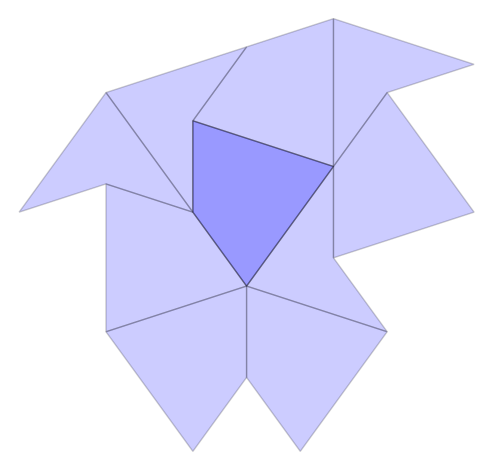

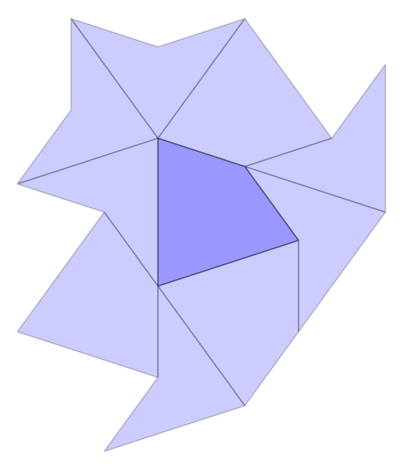

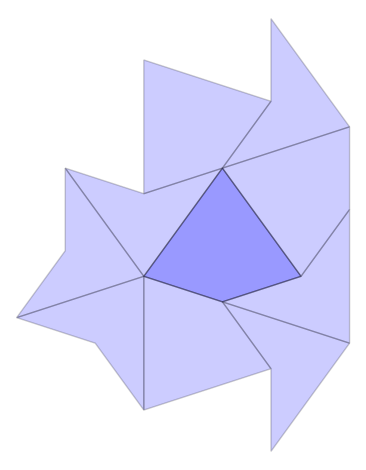

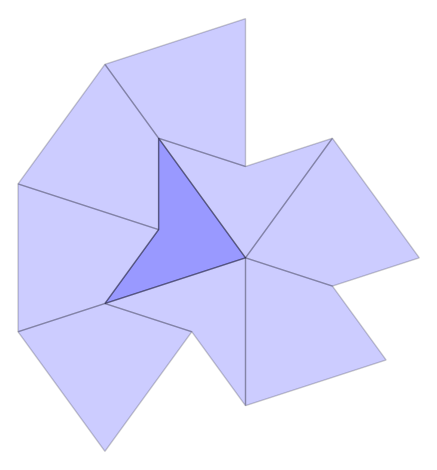

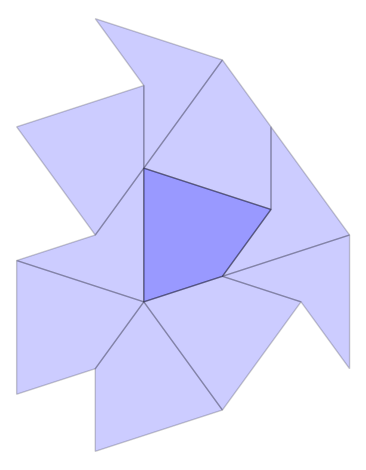

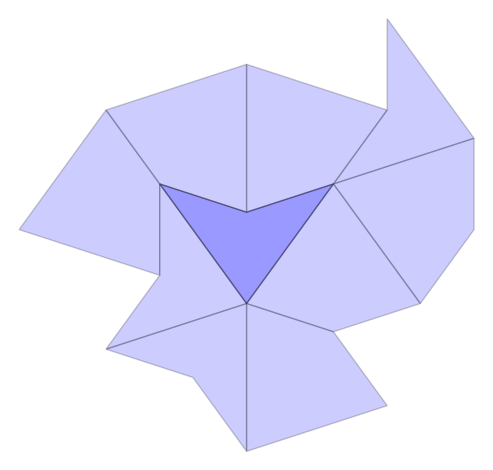

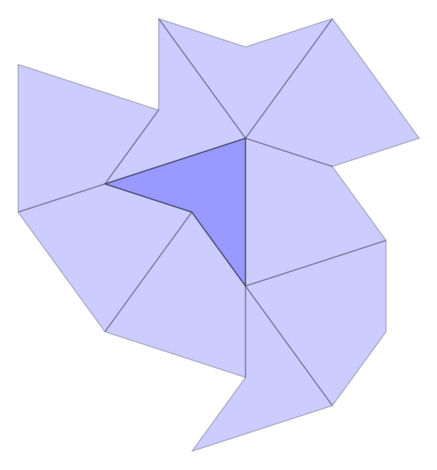

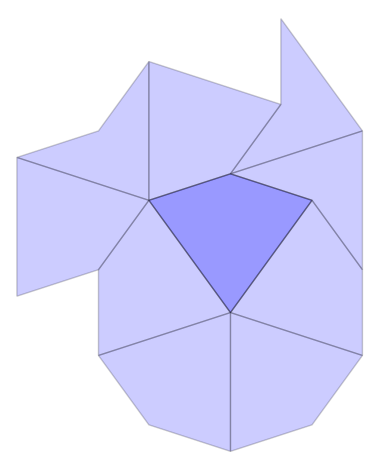

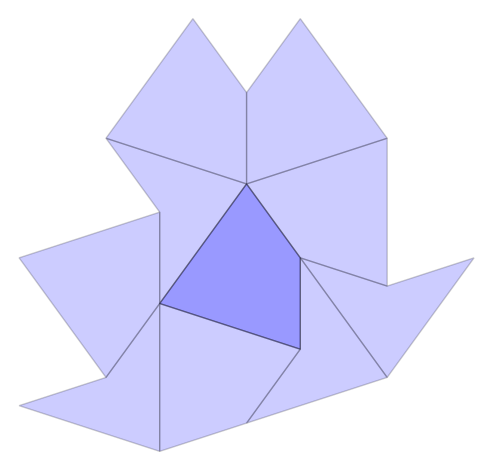

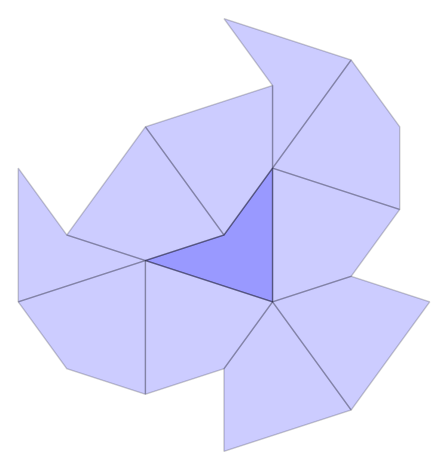

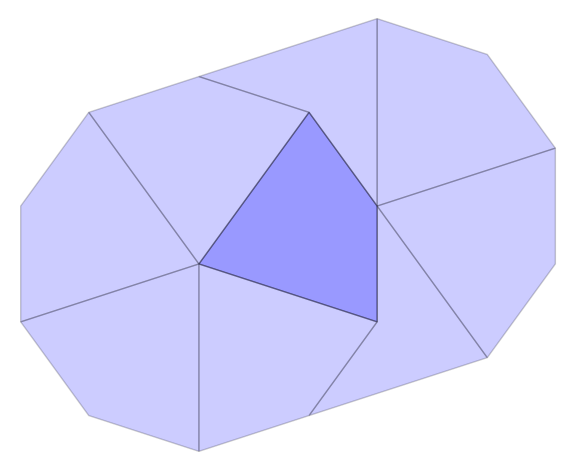

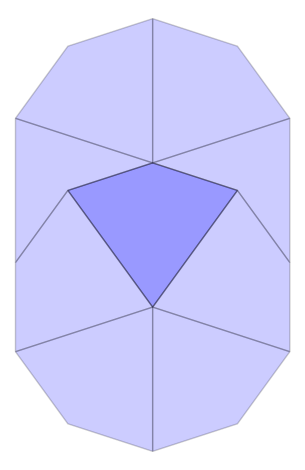

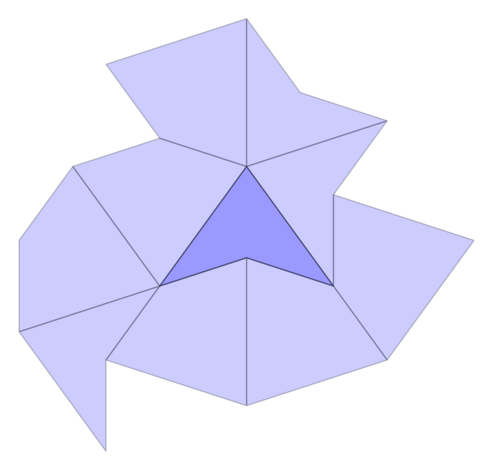

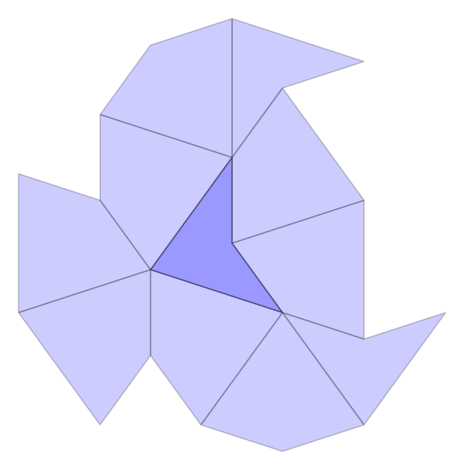

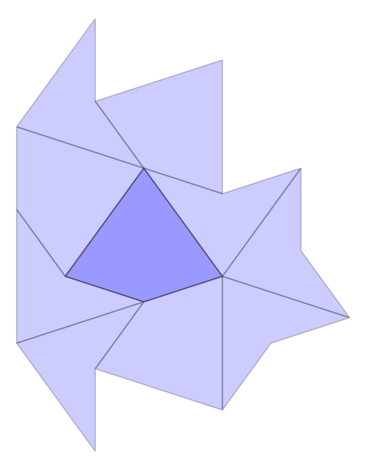

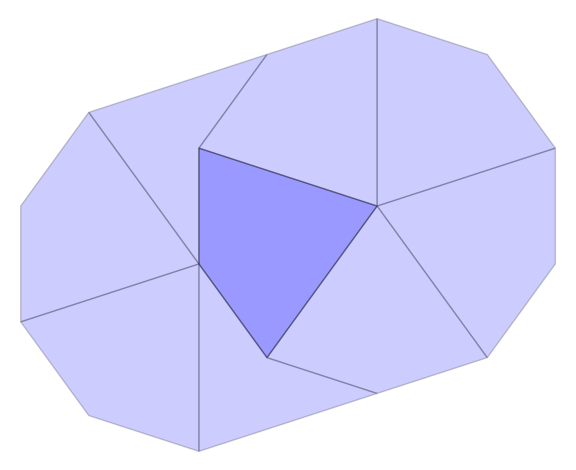

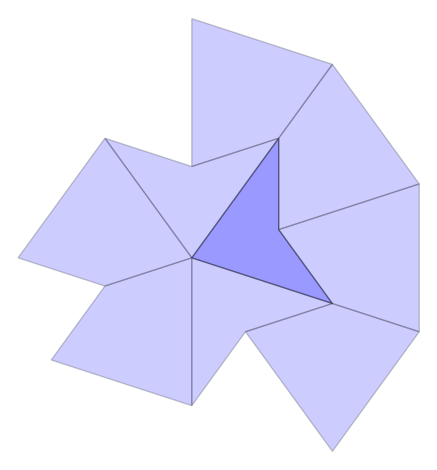

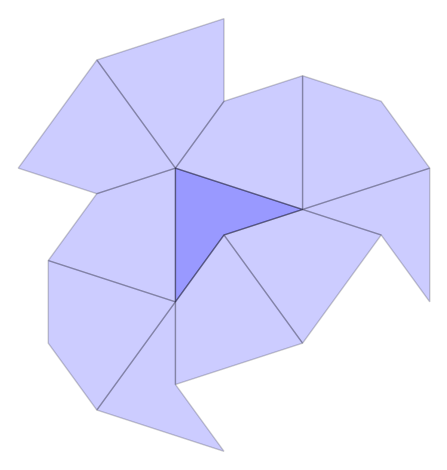

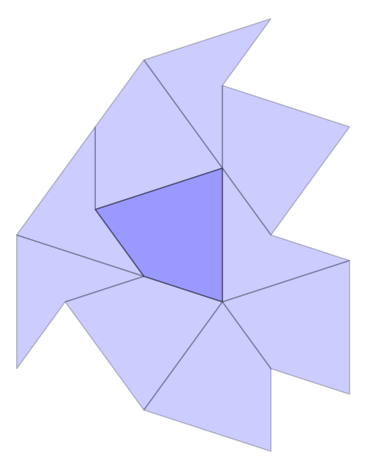

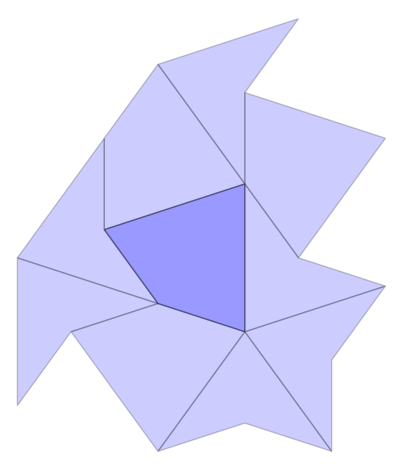

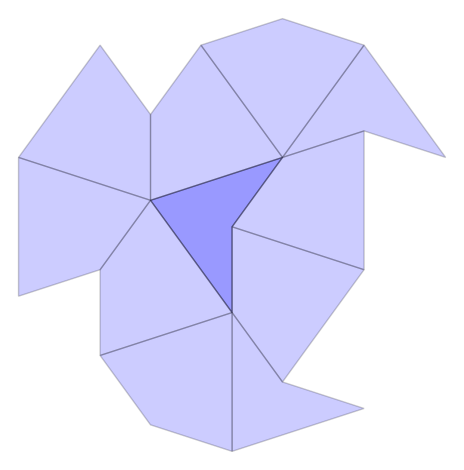

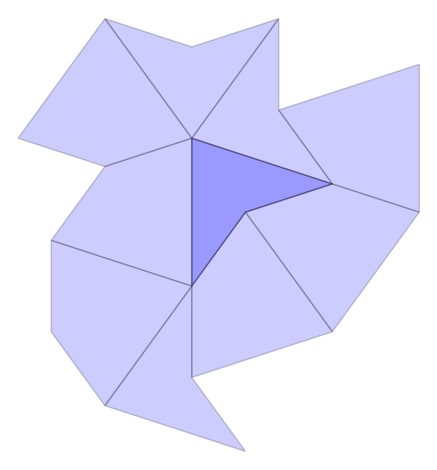

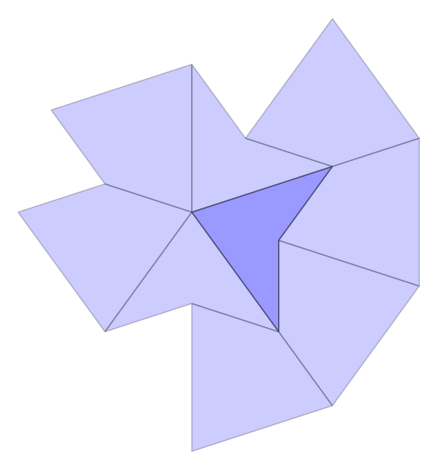

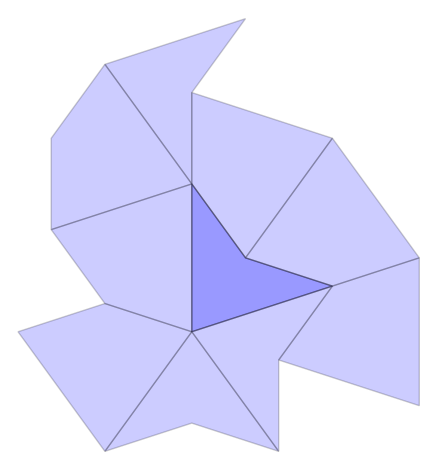

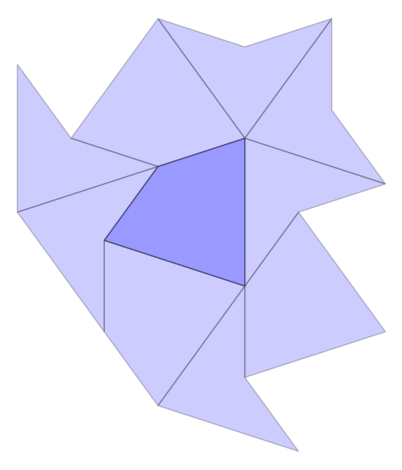

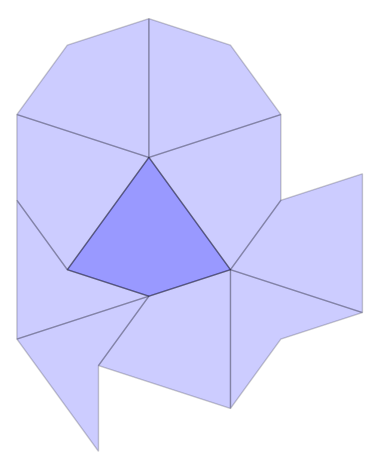

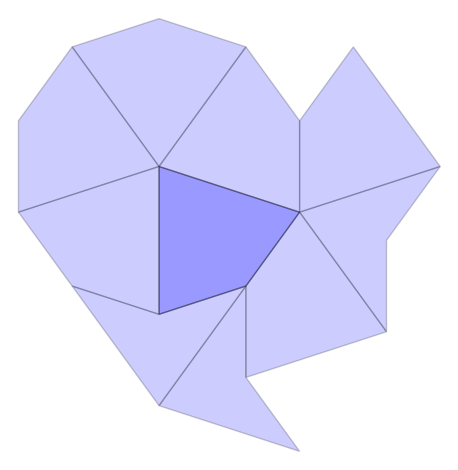

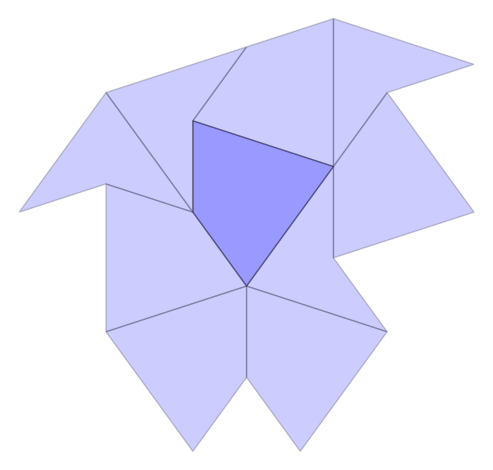

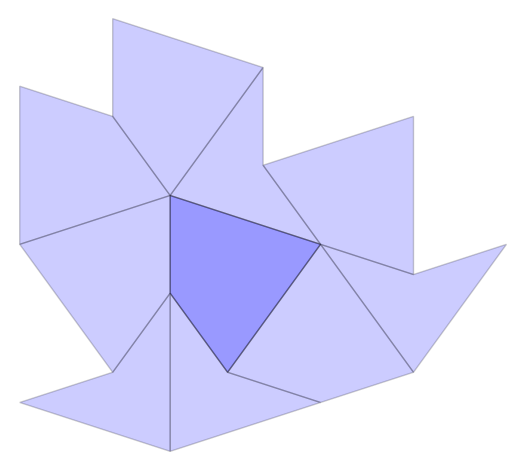

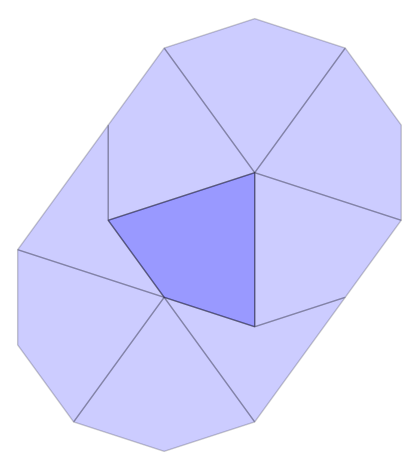

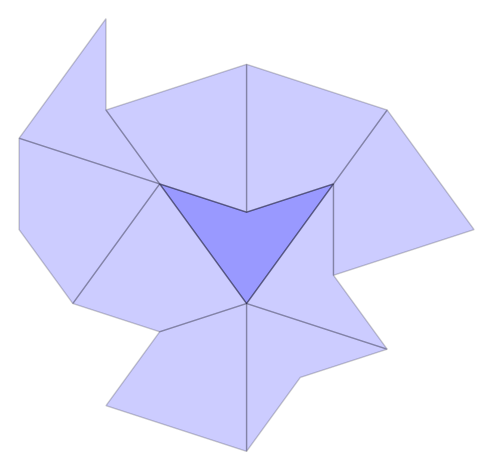

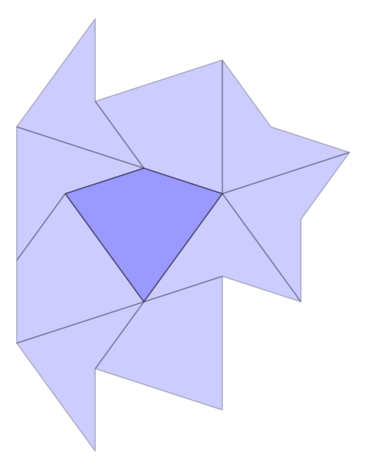

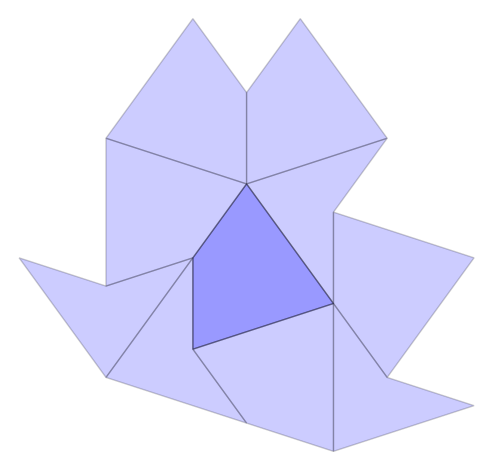

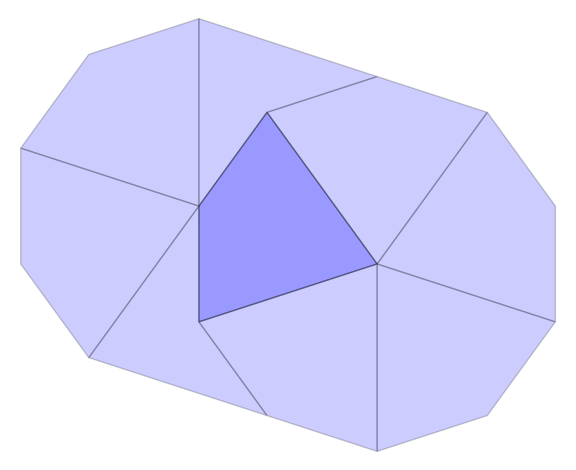

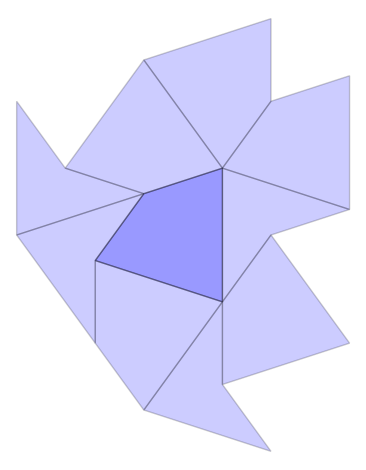

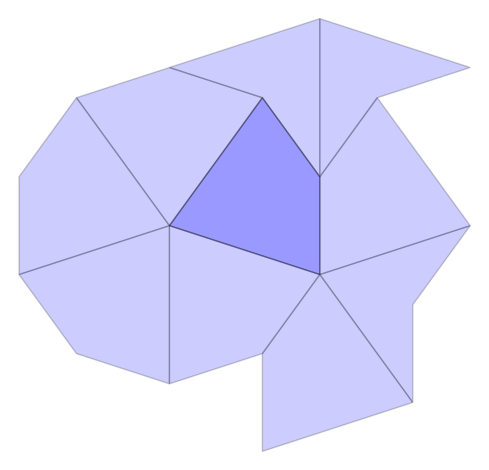

Found 374 collars!


In [49]:
num_iterations = 6

start = time.time()
collaring_test_patch = PenrosePatch()
num_collars = collaring_test_patch.find_collars_iteratively(num_iterations)
finish = time.time()

print(f"Found {num_collars} collars! Took {start - finish} seconds.")


Substituting took 25.848875284194946 seconds. 
Starting to graph...
Graphing took 25.849069833755493 seconds. 
Starting to construct matrix...
Generating adj mat took 25.85348606109619 seconds. 
Starting to display collars...


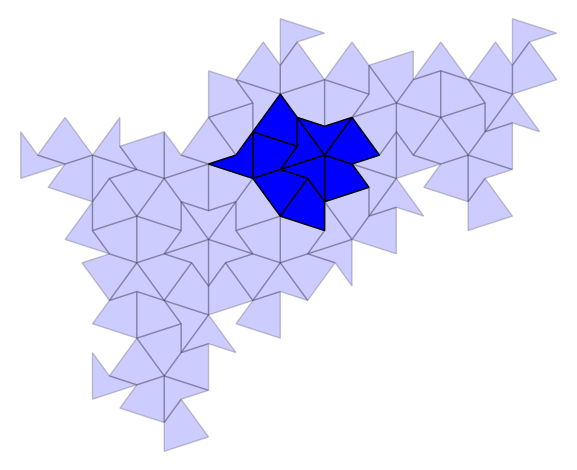

Finished in time: 26.00793480873108


In [42]:
# Testing for PenrosePatch
start = time.time()
level = 5

test_patch = PenrosePatch()
test_patch.add_prototile_code("D0", (0,0))

# test_patch_2 = PenrosePatch()
# test_patch_2.add_prototile_code("K4", (1/4*(sqrt(5) + 1)*sqrt(1/2*sqrt(5) + 5/2), 1/8*(sqrt(5) + 3)*(sqrt(5) + 1)))

# test_patch_3 = PenrosePatch()
# test_patch_3.add_prototile_code("D8", (1/4*(sqrt(5) + 1)*sqrt(1/2*sqrt(5) + 5/2) - 1/2*sqrt(2*sqrt(5) + 5), 1/8*(sqrt(5) + 3)*(sqrt(5) + 1) - 1/2))

    
for j in range(level):
    test_patch.substitute_patch()
    # test_patch_2.substitute_patch()
    # test_patch_3.substitute_patch()
    P = test_patch.graph_patch()
print(f"Substituting took {time.time() - start} seconds. \nStarting to graph...")
# show(test_patch.graph_patch())

print(f"Graphing took {time.time() - start} seconds. \nStarting to construct matrix...")
test_patch.generate_adjacency_matrix(True)
print(f"Generating adj mat took {time.time() - start} seconds. \nStarting to display collars...")

test_patch.remove_border_tiles()
for tile in test_patch.border_tiles:
    P += polygon(test_patch.prototile_vertices[tile], fill=True, alpha=1, thickness=1, edgecolor='black', rgbcolor = "blue", axes=False)


show(P)
end = time.time()
print(f"Finished in time: {end - start}")


Rotated by 0*pi/5


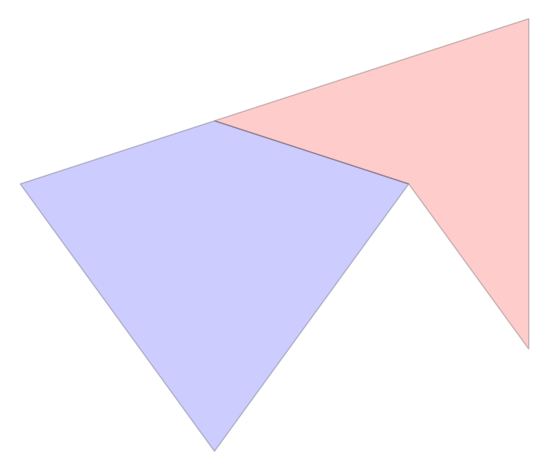

(0, 0)
0
(-4*a^3 + 3*a, -2*a^2 + 2)
4/5*pi
Rotated by 1*pi/5


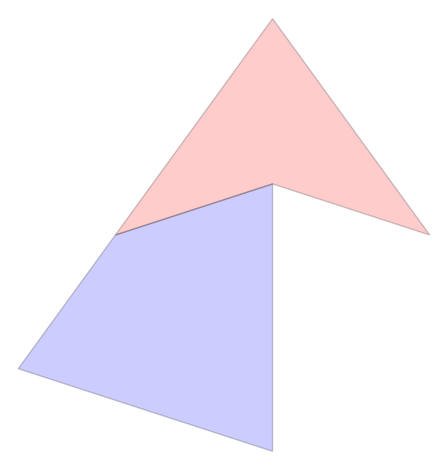

(0, 0)
1/5*pi
(0, -4*a^2 + 3)
pi
Rotated by 2*pi/5


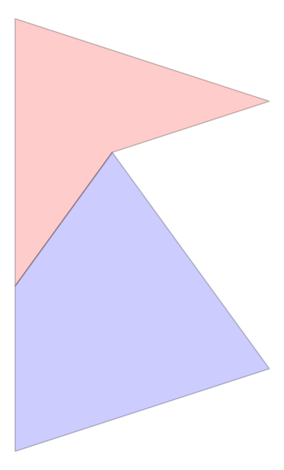

(0, 0)
2/5*pi
(4*a^3 - 3*a, -2*a^2 + 2)
6/5*pi
Rotated by 3*pi/5


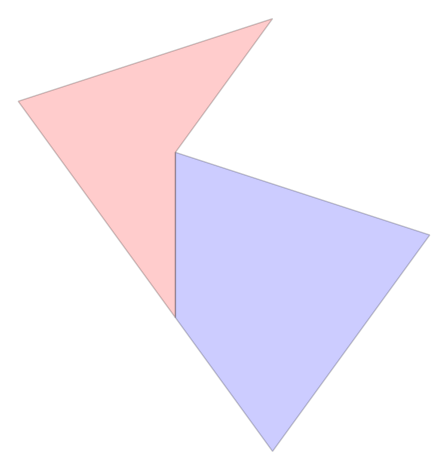

(0, 0)
3/5*pi
(4*a^3 - 4*a, 1/2)
7/5*pi
Rotated by 4*pi/5


KeyboardInterrupt: 

In [34]:
# Tool to display origin, rotation, vertices for different prototiles.

for i in range(10):
    print(f"Rotated by {i}*pi/5")
    test2 = PenroseTile(dart, 1, i*pi/5, vector(QQ[sin(pi/5)], (0,0)), None)
    
    P = test2.graph(false, 'red')
    P.show()
    
    for t1 in test2.subtiles:
        print(t1.origin)
        print(t1.orientation)

Finished in time: 52.97447633743286


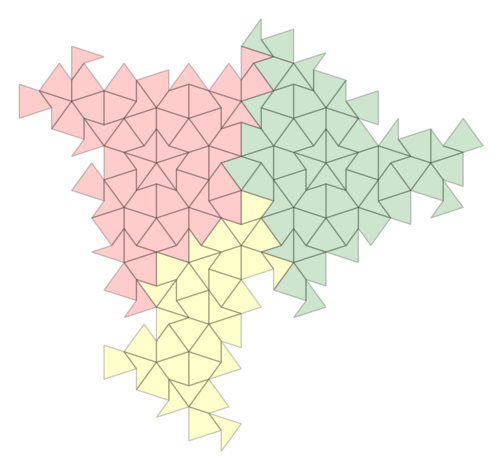

In [127]:


start = time.time()
test = PenroseTile(kite, 5, 0, vector(QQ[sin(pi/5)], (0,0)), None)
P = test.graph(True, 'red', 'blue')
end = time.time()
print(f"Finished in time: {end-start}")

# f = 1.615
# n=6
# large_kite = polygon([(0,0), (f**n*cos(3*pi/10), f**n*sin(3*pi/10)), (0, f**n*(sin(3*pi/10) + sin(pi/10)*sec(pi/5)/2)), (-(f**n)*cos(3*pi/10), f**n*sin(3*pi/10))], 
#                      fill=false, rgbcolor='black')
# P += large_kite

P.show()
# P.save('Penrose_Dart_6_outline.png')
            

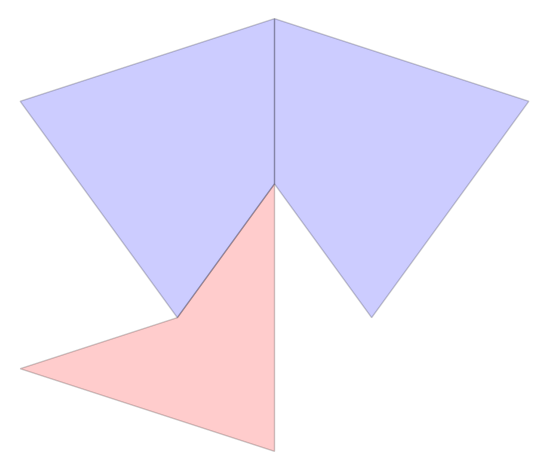

NameError: name 'Patch' is not defined

In [102]:
# Find all the collars present within a certain supertile

sup_tile_level = 1
num_collars = 0
sup_tile = PenroseTile(kite, sup_tile_level, 0, vector(QQ[sin(pi/5)], (0,0)), None)
sup_tile.build_adj_matrix()

collars_found = set()

P = sup_tile.graph(false)
P.show()

for p_tile in sup_tile.prototile_ids:
    if (p_tile == None): break
    patch = Patch()
    
    s = find_k_neighbors(sup_tile, p_tile, 1)
    patch.add_tile(p_tile)

    for t in s:
        patch.add_tile(t)

    if patch in collars_found:
        continue

    collars_found.add(patch)
    num_collars += 1
    G = patch.display_patch(p_tile)
    # G.save(f'Penrose_Collar_{num_collars}.png')

print(f"Found {num_collars} collars in a supertile of level {sup_tile_level}")

In [5]:
# A patch represents a group of tiles. Specifically, we want one to represent a group of tiles
# which are all neighboring, and which form a k-collar of the central tile. 
class Patch:
    def __init__ (self):
        self.tiles = set()
        self.parent = None
        self.hash = set()

    # Add a tile to this patch. If the patch does not yet have any tiles in it,
    # then mark its parent as the first tile added. Tiles in a patch are given as
    # lists of points relative to the parent tile, so two patches that are the same
    # up to translation are equivalent as Patch objects.
    def add_tile(self, tile):
        if self.parent == None:
            self.parent = tile

        # Maintain a list of certain values to use to hash a Patch object. Specifically,
        # we want patches to have the same hash if they have the same prototiles arranged
        # in the same way. This seems to work for now but might need tweaking in the future.
        # self.hash.add(tile.orientation)
        for p in tile.points:
            self.hash.add((tile.orientation, p[0] - self.parent.origin[0], p[1] - self.parent.origin[1]))

        tile_pts_relative = tuple((vector((p[0] - self.parent.origin[0], p[1] - self.parent.origin[1]), immutable=True) for p in tile.points))
        self.tiles.add(tile_pts_relative)

    # Displays the patch graphically, with tile marked in red.
    def display_patch (self, tile=None):
        G = Graphics()
        for t in self.tiles:
            G += polygon(t, fill=false)

        if tile != None:
            highlight_points = [vector((p[0] - self.parent.origin[0], p[1] - self.parent.origin[1])) for p in tile.points]
            G += polygon(highlight_points, fill=true, rgbcolor=(1,0,0), alpha=0.5, axes=false)
                
        return G

    def display_patch_no_highlight (self):
        G = Graphics()
        for t in self.tiles:
            G += polygon(t, fill=false)

        return G

    # Compares two patches. Specifically, this returns True if both patches have the
    # same tiles in the same relative positions. So two patches are equal if one is 
    # a translation of the other to somewhere else in the plane. 
    def __eq__ (self, other):
        if type(self) != type(other):
            return False

        # This is probably bad style, but works for now. TODO: make this more explicit
        return self.__hash__() == other.__hash__()
    
    # See add_tile for details. Two patches should have the same hash if they contain the
    # same pattern of prototiles. To enforce this, we keep a set (which we cast to frozenset
    # to hash) which contains the orientations and origins of each prototile in the patch. 
    # Something to consider: can two patches have the same number of different origins/orientations
    # and not be equal, i.e. not have the same pattern? I don't know.
    def __hash__ (self):
        # Definitely bad style, but this is fine as long as we don't change a patch object after hashing.
        return hash(frozenset(self.hash))

In [6]:
# Same as find_neighbors, but uses an adjacency matrix to find the neighbors. This is much faster,
# and we can also quickly find the k-neighborhood instead of just the 1-neighborhood. 
def find_k_neighbors(s_tile, p_tile, k):
    neighborhood = set()
    mat = Matrix(s_tile.adj)^k
    for t in range(len(s_tile.adj)):
        if mat[p_tile.id, t] >= 1 and p_tile.id != t:
            neighborhood.add(s_tile.prototile_ids[t])

    return neighborhood